# MEANtools (Metabolite ANticipation tools)

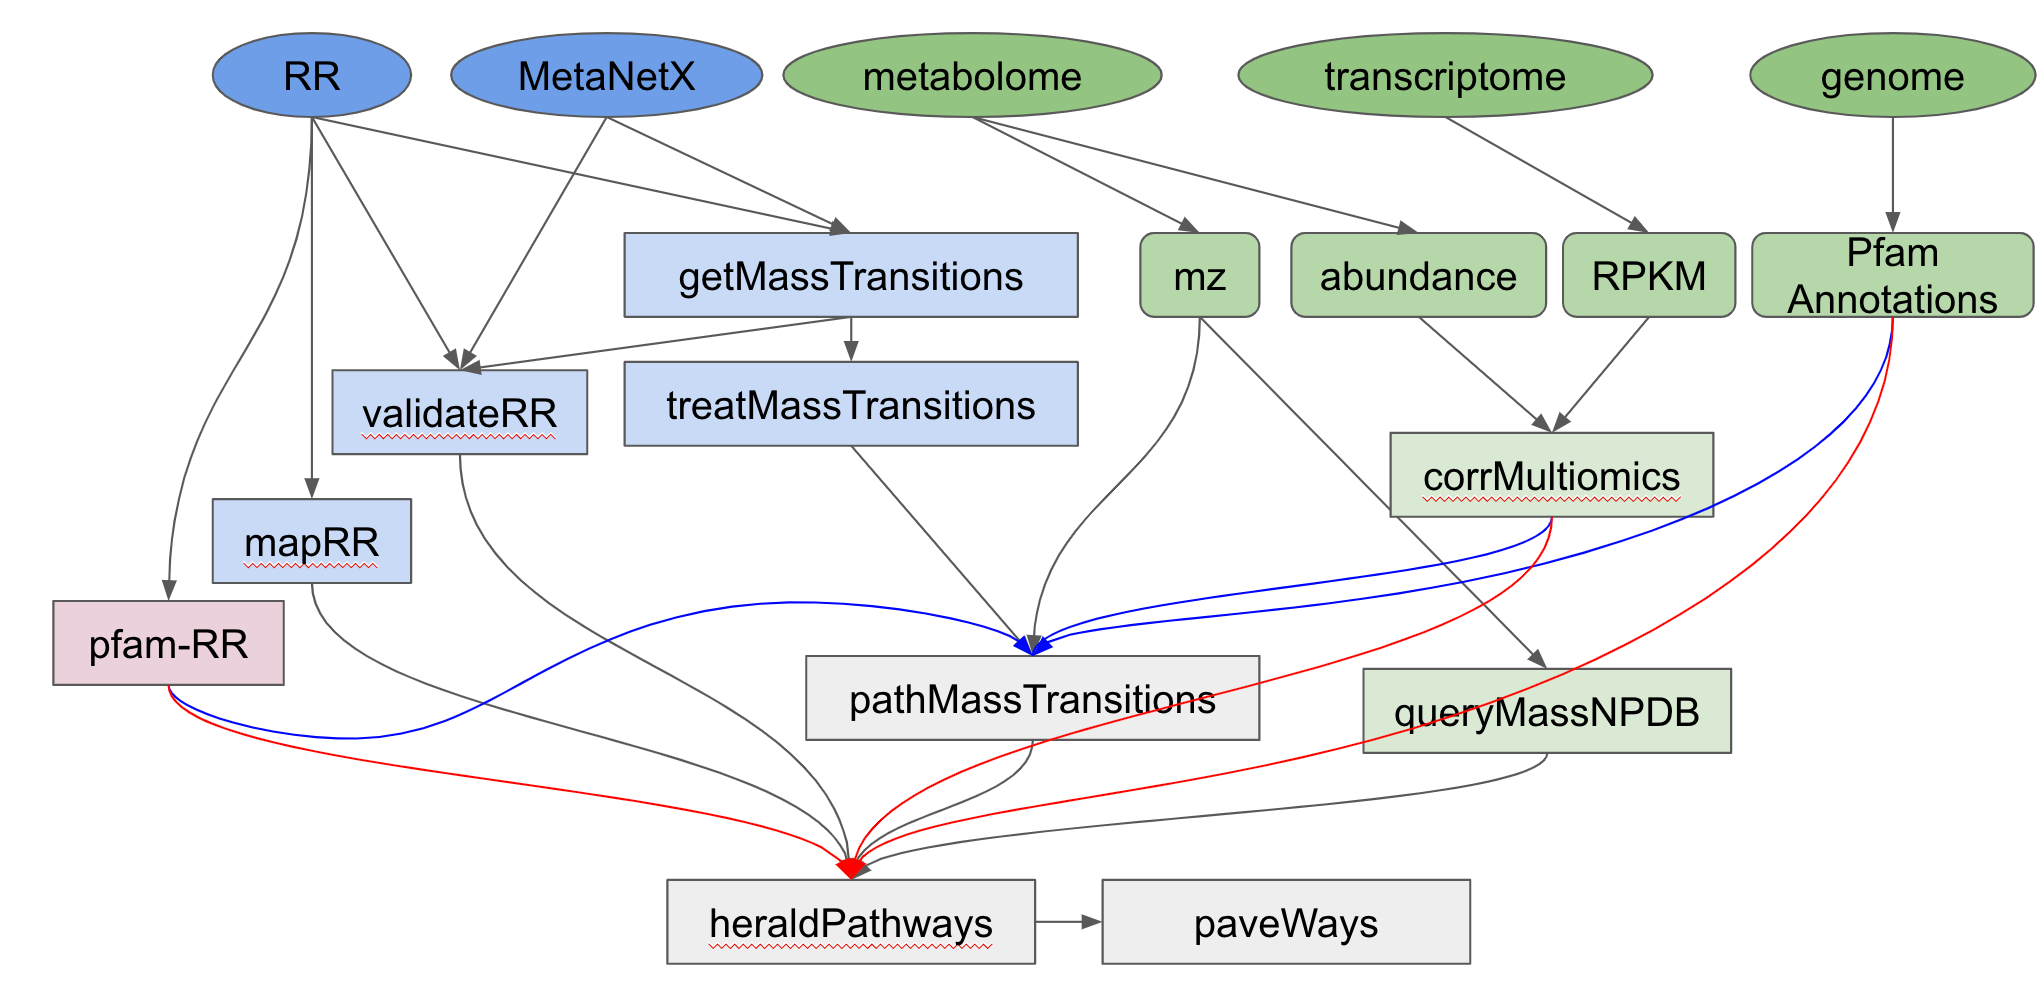

In [4]:
from IPython import display
display.Image("workflow.png")

### Arrows:
Arrows in this workflow show where the input of which script comes from.
Grey arrows show the simplest workflow: only using metabolome information.
Red and blue arrows show the additional steps when using transcriptome data as well. Introducing transcriptomic data acts as a filter: reactions without associated correlated transcripts are filtered out. Because of this, when using the blue arrows (recommended), the red arrows are not necessary.

### Squares:
Blue-colored squares are the DATABASE PREPARATION phase. These scripts parse the RetroRules database to extract the data pertinent to MEANtools. These steps only need to be performed once: upon downloading the RetroRules database.
Green-colored squares are the OMICS DATA PREPARATION phase.
Red-colored square is a list annotating the data from the RetroRules database and its PFAM predictions. This can be downloaded from #TODO.
Grey-colored squares are the PREDICTION phase.

In [22]:
%run test_db/format_databases.py -h

## Step 1

### format_databases.py

1. This script rounds and analyses the mass_transitions generated in previous step to make it compatible with the mass transitions that will later be identified by rdkit during the virtual molecule generation process. This script also generates some plots showing the transition degeneracy (answering questions such as how many reactions can be attributed to a specific mass_transition number).
2. This script validates the SMILES in RetroRules reactions with that of the metabolites in MetaNetX. This is because some SMILES have small differences across the two databases. This script basically filters out these rules, leaving only those in which the molecular structures involved are identical as those described by MetaNetX.
3. This script parses the RetroRules and MetaNetX database to generate a CSV with reaction_ids and their associated mass_transitions
4. This script maps the relationships among rules in RR. Because the molecular structures in RR rules are all described in different diameters (substructures), many of these substructures are identical across several rules, or are substructures of more complex structures in other rules. This script identifies and output these relationship to optimize the speed at which rules are tested with the metabolome data.

*For example*, this script will identify that a rule involving the substructure C-N-C does not need to be tested for a specific molecule if a rule involving the substructure C-N was already tested and was not found in the molecule.

**Base rules**: are the reaction rules that describe substructures that cannot be further decomposed in smaller substructures that are also in RetroRules. Base rules represent step number one in testing the metabolome data.

**Small rules**: are the reaction rules described at their smallest diameter, as found in RR.


In [30]:
from IPython import display
display.Image("test_db/format_database/transitions_degeneracy.png")

In [15]:
%%bash
#ls -la test_db/format_database/

In [11]:
%%bash
#head Jeon_tomato/test_data/test.bac.abundance.csv
#head Jeon_tomato/test_data/test.bac.rnaseq.rpkm.csv
#head Jeon_tomato/test_data/test.bac.metabolome.csv

In [19]:
%run queryMassNPDB_mod.py -h

In [17]:
%%bash
#cat docs/ESI-MS-adducts.csv

In [21]:
%run queryMassNPDB_mod.py -add docs/ESI-MS-adducts.csv -ms Jeon_tomato/test_data/test.bac.metabolome.csv -db lotus -dbp demo.sqlite -dtn Jeon_dummy_falcarindiol -t Solanum -dn test.sqlite -tn test_metabolites -c 20 -p 20 -v True

## STEP 2

In [ ]:
%run corrMultiomics_mod.py -h

In [12]:
%run corrMultiomics_mod.py -ft Jeon_tomato/test_data/test.bac.abundance.csv -qm Jeon_tomato/test_data/test.bac.rnaseq.rpkm.csv -mr -cl -mad -r -c 0.1 -w 0.01 -mdr 5 10 25 50 -t 4 -dn test.sqlite -tn bacterial

In [ ]:
%run merge_clusters.py -h

In [25]:
from IPython import display
display.Image("overlap.png")

In [27]:
%run merge_clusters.py -ft Jeon_tomato/test_data/test.bac.abundance.csv -qm Jeon_tomato/test_data/test.bac.rnaseq.rpkm.csv -a -f Jeon_tomato/annotation/tomato.new.pfams_description.csv -mc -mm overlap -dr 25 -dn test.sqlite

## STEP 3


### pathMassTransitions.py
This script integrates the metabolome and transcriptome data with the RR and MetaNetX data. In short, this script filters the mass transitions associated with RR reactions according to the mass signatures found in the metabolome. In this manner, if the metabolome has no metabolites with a mass of a 1000, then reactions involving masses of a 1000 are filtered out.

Important optional arguments:

**--ghost**: Adds "ghost" mass signatures; these are metabolites that cannot be measured in the metabolome. Each ghost mass signature is linked to at least two other metabolites that can be measured.

**--corr_cutoff** and **--corr_p_cutoff** to filter the correlation input through custom thresholds.

**--pfam_RR_annotation_dataset** to filter the associations between pfams and RR reactions (which are often predictions).

In [31]:
%run pathMassTransitions_mod.py -h

In [ ]:
%run pathMassTransitions_mod.py -c Jeon_tomato/test_data/test_merged_cluster_filtered.csv -t test_db/format_database/MassTransitions.csv -dn test.sqlite -tn transitions_test_falca -ct bacterial -mt test_metabolites -p pfam_RR_annotation_file.csv -a Jeon_tomato/Bacterial/bacterial.tomato.pfams.sol.csv -s loose -cc 0.1 -cpc 1 -v

### heraldPathways.py

This is script is the heart of the prediction process.

This script integrates all data to produce pathway predictions. Here, all input is integreated, and all results are output as CSV tables, EXCEL, cytoscape. However, these results relate to the entire -omics data used. It is advised to use **paveWays.py** to further filter out the results and generate visualizations or filtered tables of predicted pathways that are easier to interpret.

The inputs from the red arrows (in the flowchart above) are not necessary if they have been used in the blue arrows.

The following optional argument is VERY important:

**--iterations**
The script will test structures in separate iterations. If setting this parameter to 1, then only the input structure (reaction substrates) will be tested, generating an additional set of substructures (virtual molecules, reaction products) and therefore the longest pathway that (often) will be predicted will be one-reaction-long. If using iterations=2, then the virtual molecules predicted from the first iterations, will also be tested, generating a third set of molecules (virtual molecules, reaction products of the second set of molecules). Therefore, the larger this parameter, the longer the pathways that can be predicted, however, each new iteration will (likely) result in a larger set of molecules than the previous one, so handle with care according to computing, memory and time limitation.

**TIP**: Use all structures of an expected pathway as input and select iterations=1. The script will only test one reaction per structure, but if the script manages to recover/predict the correct reactions, it will result in a predicted pathway longer than one-reaction-long despite only using iterations=1 (because all input structures should be one-reaction-away from at least one other input structure).

Important optional arguments if using red arrows (flowchart above):

_--corr_cutoff_ and _--corr_p_cutoff_ to filter the correlation input through custom thresholds.
_--pfam_RR_annotation_dataset_ to filter the associations between pfams and RR reactions (which are often predictions).
Other important optional arguments:

_--use_substrate_mm_in_file_ Recommended. This flag causes the script to use the monoisotopic mass of each input structure as given in the file. If not used, then the mm will be calculated through rdkit, which may be unnessary and computer intensive.
_--only_query_small_ with this option, reactions will be tested only at the smallest diameter.

In [ ]:
%run heraldPathways_mod.py -h

In [ ]:
%run heraldPathways_mod.py -c Jeon_tomato/test_data/test_merged_cluster_filtered.csv -r test_db/format_database/ValidateRulesWithOrigins.csv -m test_db/format_database/base_rules.csv -p pfam_RR_annotation_file.csv -a Jeon_tomato/Bacterial/bacterial.tomato.pfams.sol.csv -s loose -i 3 -dn test.sqlite -tn test_herald -ct bacterial -mt test_metabolites -tt transitions_test_falca -v -dv -o test_herald -d pfams_dict.csv

In [36]:
%%bash
#ls test_herald
#head test_herald/summary.csv
#head test_herald/reactions.csv

### paveWays.py

This script creates tables and visualizations from the predicted reactions that are easier to interpret by filtering according to user input.

The mandatory input of this script is the structure predictions of heraldPathways. When using only this input, this script will generate SVGs of all structures predicted, which can be easily browsed to find interesting predicted structures and their ID

In [38]:
%run paveWays.py -h

In [2]:
%run paveWays.py -sp test_herald/structure_predictions.csv -of test_paveWays -r test_herald/reactions.csv -praf pfam_RR_annotation_file.csv -gaf Jeon_tomato/Bacterial/bacterial.tomato.pfams.sol.csv -rr loose -pam True -pup True -v